In [1]:
# !/usr/env python3

'''
Output:
video captioning model itself and produce loss curve

Usage:
main document to train the video captioning model
'''

# set up
from __future__ import print_function
import tensorflow as tf
import pickle
import os
import numpy as np
import logging
import matplotlib.pyplot as plt
from util import *
from model.video_caption import sequence_2_sequence_LSTM

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# define parameters

logging.basicConfig(level=logging.INFO)
#=======Change These===============================
tf.app.flags.DEFINE_string("model_name", "baseline_1", "name of the model")
tf.app.flags.DEFINE_integer("state_size", 200, "Size of each model layer.")
tf.app.flags.DEFINE_float("learning_rate", 1e-4, "Base Learning rate.")
#==================================================

tf.app.flags.DEFINE_float("input_size", 7*7*512, "input size for each frame")
tf.app.flags.DEFINE_integer("batch_size", 50, "how many videos put per run")
tf.app.flags.DEFINE_integer("max_sentence_length", 20, "maximum captioning sentence length")
tf.app.flags.DEFINE_integer("word_vector_size", 50, "word embedding dimension default is 25 for twitter glove")
tf.app.flags.DEFINE_integer("vocabulary_size", 22719, "vocabulary size")
tf.app.flags.DEFINE_integer("n_epochs", 100, "number of epoch to run")
tf.app.flags.DEFINE_integer("num_frames", 15, "number of frames per video")
tf.app.flags.DEFINE_integer("hidden_size", 100, "output size of LSTM encoder and decoder")
FLAGS = tf.app.flags.FLAGS        

In [3]:
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

curPath = os.getcwd()
dataPath = curPath + "/datasets/"

# only pick first 100 for debugging purpose
# load data
sample_size = 1000
wvector_dim = 50
is_training = True
input_frames_train, captions_train, \
        word_dict, word2Index, index2Word = load_caption_data(sample_size, dataPath, train = is_training)
word_embedding = word_embedding_array(word_dict, wvector_dim, word2Index) 
print('Finish load training data!')

Finish load training data!


In [4]:
# build model graph
tf.reset_default_graph()
model = sequence_2_sequence_LSTM(word_embedding, FLAGS)
model.build()

start building model ...
batch caption shape:  (?, 20, 22719)
batch pred shape:  (?, 20, 22719)
loss shape:  ()
total number of parameter 12430619


In [26]:
# check variables
for v in tf.trainable_variables():
    print(v)

<tf.Variable 'LSTM_seq2seq/encoder/basic_lstm_cell/weights:0' shape=(25188, 400) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/encoder/basic_lstm_cell/biases:0' shape=(400,) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/basic_lstm_cell/weights:0' shape=(150, 400) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/basic_lstm_cell/biases:0' shape=(400,) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/hidden_to_word/kernel:0' shape=(100, 22719) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/hidden_to_word/bias:0' shape=(22719,) dtype=float32_ref>



  0%|          | 0/100 [00:00<?, ?it/s]


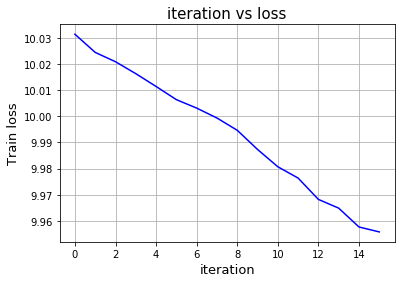

  1%|          | 1/100 [00:12<20:27, 12.40s/it]

Epoch 0: train loss 9.993658065795898, validation loss 9.950190544128418


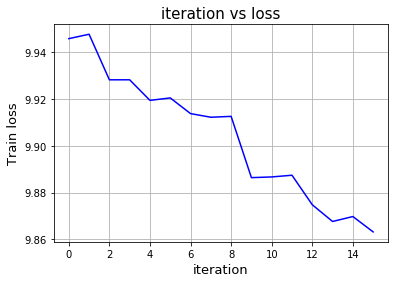

  2%|▏         | 2/100 [00:24<20:03, 12.29s/it]

Epoch 1: train loss 9.904062271118164, validation loss 9.84755802154541


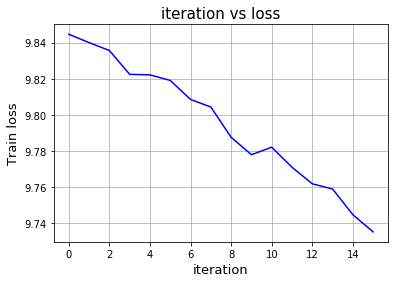

  3%|▎         | 3/100 [00:36<19:53, 12.31s/it]

Epoch 2: train loss 9.79468059539795, validation loss 9.725069046020508


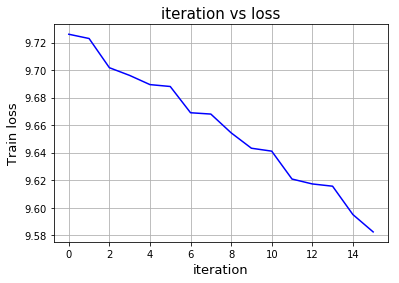

  4%|▍         | 4/100 [00:49<19:44, 12.33s/it]

Epoch 3: train loss 9.658187866210938, validation loss 9.567328453063965


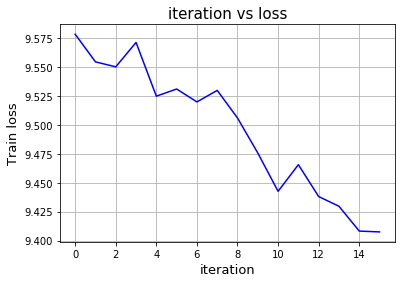

  5%|▌         | 5/100 [01:01<19:32, 12.34s/it]

Epoch 4: train loss 9.495776176452637, validation loss 9.386819839477539


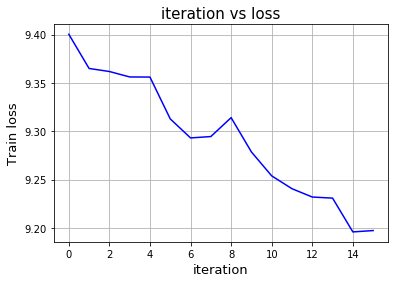

  6%|▌         | 6/100 [01:13<19:14, 12.28s/it]

Epoch 5: train loss 9.29262638092041, validation loss 9.170499801635742


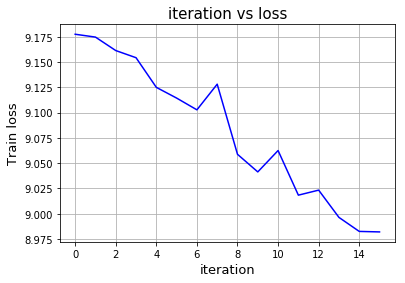

  7%|▋         | 7/100 [01:27<19:47, 12.77s/it]

Epoch 6: train loss 9.081470489501953, validation loss 8.947248458862305


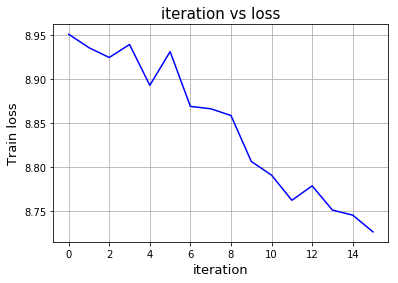

  8%|▊         | 8/100 [01:39<19:18, 12.59s/it]

In [ ]:
# run training mode
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    val_loss, tr_loss, tr_pred, val_pred, embeddings \
            = model.train(sess, (input_frames_train, captions_train), verbose = True)

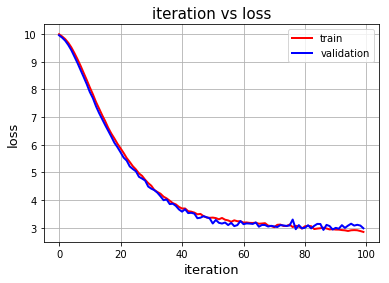

In [30]:
# plot learning curve
plt.plot(range(len(tr_loss)), tr_loss, 'r-', linewidth = 2, label = 'train')
plt.plot(range(len(val_loss)), val_loss, 'b-', linewidth = 2, label = 'validation')
plt.grid()
plt.xlabel('iteration', fontsize = 13)
plt.ylabel('loss', fontsize = 13)
plt.title('iteration vs loss', fontsize = 15)
plt.legend()
plt.savefig(os.getcwd() + '/output/caption_learning_curve.png')

In [38]:
# check one caption
batch_size = 50
idx = np.random.randint(batch_size)
sample = tr_pred[idx]
words = []
embed_train = False # whether train embedding word
print('sample: ', sample)
# caption

# # nearest neighbor searching
for i in range(20):
    best_error = float('inf')
    word_vec = sample[i]
    print('Word vec :', word_vec.shape)
    if embed_train:
        for row in range(embeddings.shape[0]):
            vec = embeddings[row]
            word = index2Word[row]
            if np.sum(vec) == 0: continue
            error = np.sum(np.square(word_vec - vec))
            if error < best_error:
                w = word
                best_error = error
    else:
        for word, vec in word_dict.items():
            if len(vec) == 0: continue
            error = np.sum(np.square(word_vec - vec))
            if error < best_error:
                w = word
                best_error = error
    words.append(w)
    
print('Test Caption: ', ' '.join(w for w in words))

sample:  [[-6.05092382 -6.00588512 -5.87462091 ..., -2.39618874 -5.68410158
  -5.83877182]
 [-4.90358019 -4.87364435 -4.82394171 ..., -2.13190079 -4.66670132
  -4.86364269]
 [-4.71824121 -4.72110033 -4.61461639 ..., -2.25243068 -4.66252518
  -4.56648874]
 ..., 
 [-5.35327053 -5.1800952  -5.40557861 ..., -2.26493835 -5.38118744
  -5.33628511]
 [-5.86696005 -5.92697573 -5.74634838 ..., -2.37389445 -5.77933455
  -5.82372189]
 [-6.47454166 -6.52930498 -6.7256465  ..., -2.92361188 -6.59594822
  -6.41689682]]
Word vec : (22719,)


ValueError: operands could not be broadcast together with shapes (22719,) (50,) 

In [14]:
len(word_dict)

22719

In [15]:
for batch in minibatches(input_frames_train, captions_train, 50, 20):
    inp, cap = batch
    print('Captions: ', cap)
    raise

Captions:  [[   265.    270.  22428.   5190.    908.    270.  12062.  18103.    266.
     266.    266.    266.    266.    266.    266.    266.    266.    266.
     266.    266.]
 [   265.    270.  12062.  10561.   9553.   9695.   5190.  22215.  13945.
   19689.   9539.    266.    266.    266.    266.    266.    266.    266.
     266.    266.]
 [   265.  12062.   9617.    270.   9602.  19219.    266.    266.    266.
     266.    266.    266.    266.    266.    266.    266.    266.    266.
     266.    266.]
 [   265.    270.  22648.  11019.  10561.  11936.  13778.  20275.   3214.
     266.    266.    266.    266.    266.    266.    266.    266.    266.
     266.    266.]
 [   265.  12062.  13821.  19131.  16522.   1602.    266.    266.    266.
     266.    266.    266.    266.    266.    266.    266.    266.    266.
     266.    266.]
 [   265.    270.  12062.  10855.    908.  20678.  20275.  21414.  18003.
   13695.    270.   1562.    266.    266.    266.    266.    266.    266.
     2

RuntimeError: No active exception to reraise